<a href="https://colab.research.google.com/github/n0n-z/Global-Superstore/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
import random
from tqdm.notebook import tqdm

import copy

sns.set(style="darkgrid", font_scale=1.4)

In [ ]:
# Reduce stochasticity

SEED = 42

# PyTorch
torch.manual_seed(SEED)

# CUDA (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups

# NumPy
np.random.seed(SEED)

# Python's built-in random
random.seed(SEED)

In [ ]:
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

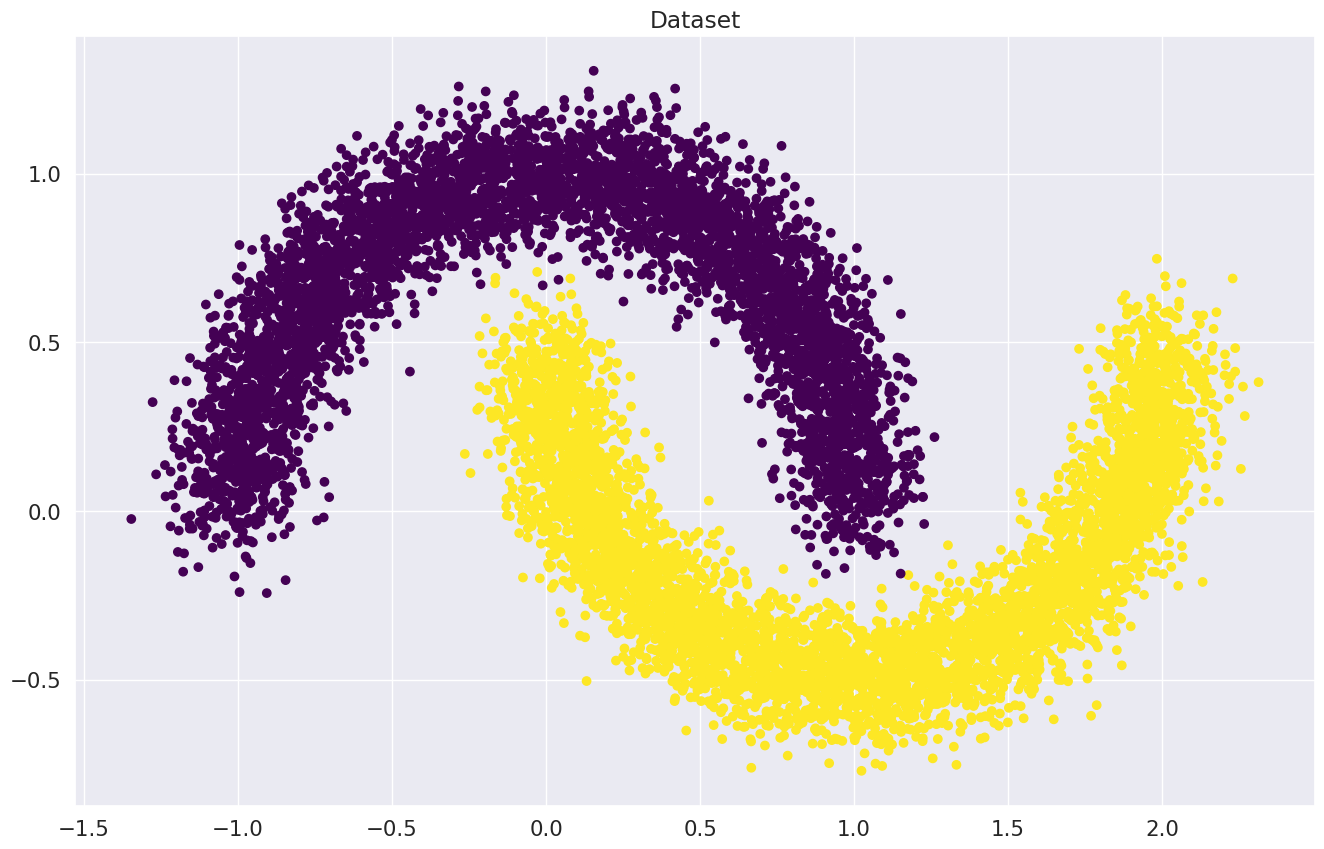

In [ ]:
# Визуализация данных

plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle = False)

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  torch.matmul(x, self.weights)
        if self.bias:
            x += self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(in_features = 2, out_features = 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [ ]:
# выход по лоссу
def train_model(model, train_dataloader, optimizer, loss_func, max_epochs, tol = 1e-3):
  '''
  args:
    model - модель для обучения
    train_dataloader - loader с обучающей выборкой
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`
    max_epochs - максимальное количество эпох обучения
    tol - порог, с которым будет сравниваться изменение loss, усредненного по эпохе
  '''

  # создадим переменные (на данный момент - пустые списки), куда будем сохранять
  # лоссы по батчам, усредненные по эпохе лоссы и параметры модели
  batch_losses = []
  epoch_mean_losses = []
  model_param_dict = []

  for epoch in range(max_epochs):
    losses = []    # переменная losses - список, куда будем добавлять значения loss по каждому батчу текущей эпохи
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        # Далее далее по коду идут стандартные операции цикла обучения:
        optimizer.zero_grad()

        outp = model(X_batch)
        # Reshape y_batch to match outp
        y_batch = y_batch.unsqueeze(1)
        loss = loss_func(outp, y_batch)
        loss.backward()

        losses.append(loss.item())
        optimizer.step()

        # Для расчета accuracy вычисляем вероятности и предсказание класса нашей моделью,
        # затем вычисляем среднее значение accuracy для текущего батча
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.float32)
        batch_acc = (preds == y_batch).sum() / y_batch.size(0)

        # через каждые 100 батчей выводим среднее значение accuracy по батчу
        if (epoch * len(train_dataloader) + it + 1) % 100 == 0:
            print(f"Iteration: {epoch * len(train_dataloader) + it + 1}\nBatch accuracy: {batch_acc}")

    batch_losses = batch_losses + losses    # добавляем список лоссов текущей эпохи к списку лоссов по батчам всех предыдущих эпох
    epoch_mean_losses.append(sum(losses)/len(losses))    # вычисляем средний по текущей эпохе лосс и добавляем к списку по предыдущим эпохам
    model_param_dict.append(copy.deepcopy(model.state_dict()))    # добавляем в список текущие значения параметров модели

    # Ниже реализован ранний выход из цикла обучения. Если разница между средним по эпохе значением loss в текущей
    # и предыдущей эпохах меньше порога tol, то оператор return завершит выполнение функции и обучение прекратится
    if epoch > 0 and abs(epoch_mean_losses[-1] - epoch_mean_losses[-2]) < tol:
          print(f"\nIteration: {epoch * len(train_dataloader) + it +1}. Convergence. Stopping iterations after {epoch + 1} epochs.")
          return batch_losses, model_param_dict

  return batch_losses, model_param_dict

In [ ]:
losses, model_param_dict = train_model(model = linear_regression,
                                                      train_dataloader = train_dataloader, optimizer = optimizer,
                                                      loss_func = loss_function, max_epochs=100, tol = 1e-3)

Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.796875
Iteration: 300
Batch accuracy: 0.7890625
Iteration: 400
Batch accuracy: 0.84375
Iteration: 500
Batch accuracy: 0.875
Iteration: 600
Batch accuracy: 0.90625
Iteration: 700
Batch accuracy: 0.8671875
Iteration: 800
Batch accuracy: 0.8203125
Iteration: 900
Batch accuracy: 0.8203125
Iteration: 1000
Batch accuracy: 0.8671875
Iteration: 1100
Batch accuracy: 0.8828125
Iteration: 1200
Batch accuracy: 0.828125
Iteration: 1300
Batch accuracy: 0.875
Iteration: 1400
Batch accuracy: 0.875
Iteration: 1500
Batch accuracy: 0.8984375

Iteration: 1593. Convergence. Stopping iterations after 27 epochs.


In [ ]:
#Вариант 2 - с помощью стандартного метода parameters() класса nn.Module
list(linear_regression.parameters())

[Parameter containing:
 tensor([[ 1.2288],
         [-3.7314]], requires_grad=True),
 Parameter containing:
 tensor([0.2708], requires_grad=True)]

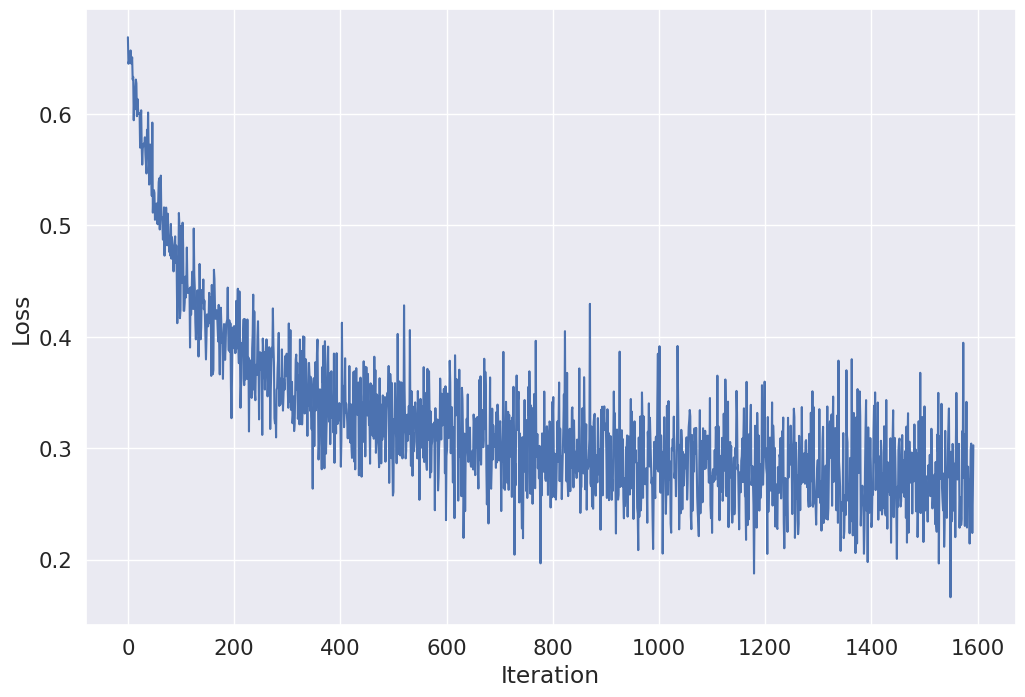

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

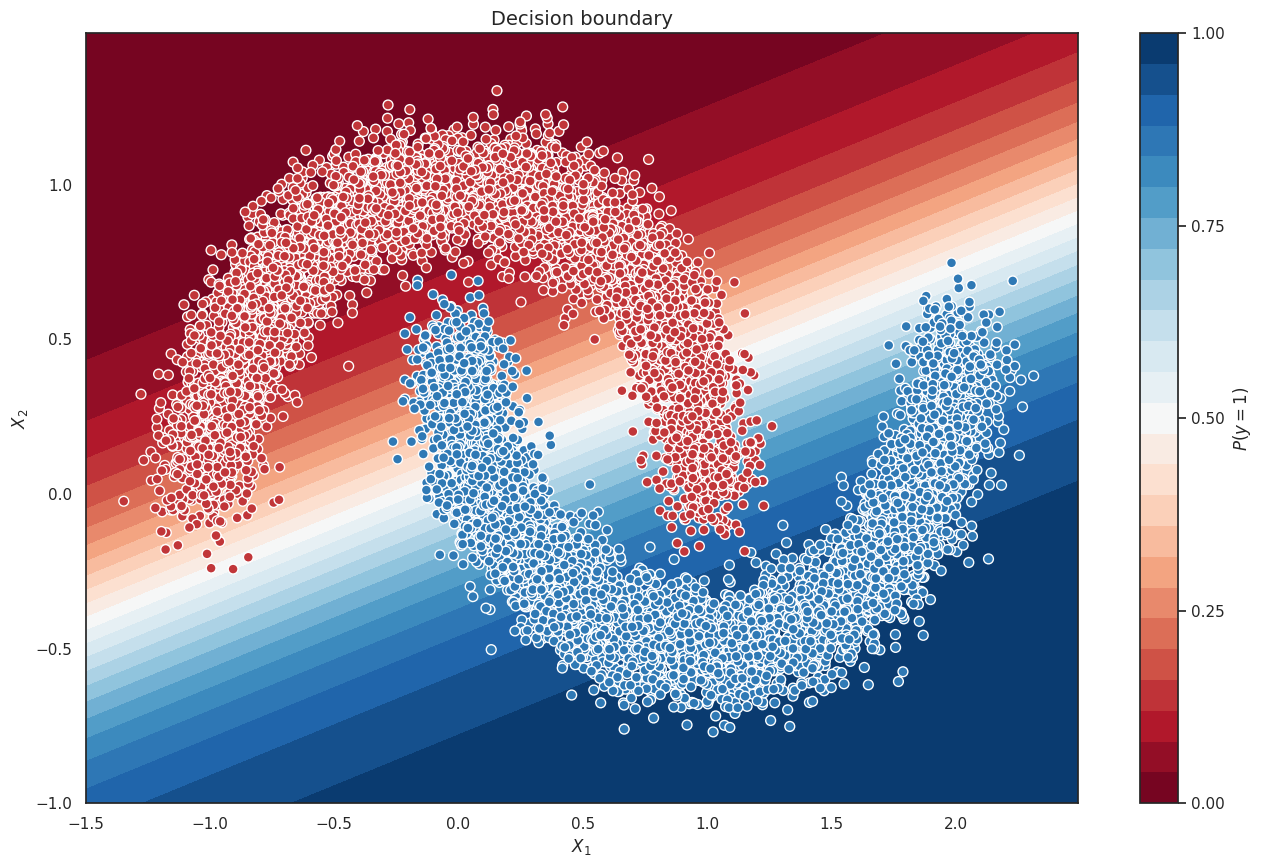

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    predictions = np.array([])
    for x_batch, _ in dataloader:
        probs = torch.sigmoid(model(x_batch))
        preds = (probs > 0.5).type(torch.float32)
        predictions = np.concatenate((predictions.reshape(-1, 1), preds.numpy()), axis=0)
    return predictions

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val, predict(val_dataloader, linear_regression)))

0.8852


In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset_MNIST = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset_MNIST  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader_MNIST = torch.utils.data.DataLoader(train_dataset_MNIST, batch_size=4, shuffle=True)
valid_dataloader_MNIST = torch.utils.data.DataLoader(val_dataset_MNIST, batch_size=4, shuffle=False)

# Далее будем использовать словарь из загрузчиков
loaders_MNIST = {"train": train_dataloader_MNIST, "valid": valid_dataloader_MNIST}

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]


In [ ]:
from torch.nn.modules.linear import Linear
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    Linear(28*28, 128),
    activation,
    Linear(128, 128),
    activation,
    Linear(128, 10)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def fit_one_epoch(model, train_dataloader, optimizer, loss_func):
  '''
  args:
    model - модель для обучения
    train_dataloader - loader с выборкой для обучения модели
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`

  функция возвращает метрику accuracy по эпохе на данных из train_dataloader
  '''

  epoch_correct_predictions = 0.0
  epoch_all_predictions = 0.0
  model.train()

  for X_batch, y_batch in tqdm(train_dataloader):
    # Далее далее по коду идут стандартные операции цикла обучения:
    optimizer.zero_grad()

    outp = model(X_batch)
    loss = loss_func(outp, y_batch)
    loss.backward()

    optimizer.step()

    # Рассчитаем accuracy. Для этого определим количество верных предсказаний
    # и общее количество предсказаний в каждом батче, а затем накопительным итогом посчитаем
    #  количество верных предсказаний и общее количество предсказаний в рамках эпохи
    preds = outp.argmax(-1)
    batch_correct_predictions = (preds == y_batch).sum()
    batch_all_predictions = len(preds)

    epoch_correct_predictions += batch_correct_predictions
    epoch_all_predictions += batch_all_predictions

  epoch_accuracy = epoch_correct_predictions/epoch_all_predictions
  return epoch_accuracy

In [ ]:
# проверим работу функции
fit_one_epoch(model = model, train_dataloader = train_dataloader_MNIST, optimizer = optimizer, loss_func = criterion)

  0%|          | 0/15000 [00:00<?, ?it/s]

tensor(0.9075)

In [ ]:
def eval_one_epoch(model, val_dataloader):
  '''
  args:
    model - модель для обучения
    val_dataloader - loader с валидационной/тестовой выборкой
  '''

  epoch_correct_predictions = 0.0
  epoch_all_predictions = 0.0
  model.eval()

  for X_batch, y_batch in tqdm(val_dataloader):

    # Далее далее по коду идут стандартные операции цикла валидации:
    with torch.no_grad():
      outp = model(X_batch)
      preds = outp.argmax(-1)

    # Рассчитаем accuracy
    batch_correct_predictions = (preds == y_batch).sum()
    batch_all_predictions = len(preds)

    epoch_correct_predictions += batch_correct_predictions
    epoch_all_predictions += batch_all_predictions

  epoch_accuracy = epoch_correct_predictions/epoch_all_predictions
  return epoch_accuracy

In [ ]:
# проверим работу функции
eval_one_epoch(model = model, val_dataloader = valid_dataloader_MNIST)

  0%|          | 0/2500 [00:00<?, ?it/s]

tensor(0.9419)

In [ ]:
def train_func(model, num_epochs, dataloaders, optimizer, loss_func):
  '''
  args:
    model - модель для обучения
    num_epochs - количество эпох
    dataloaders - словарь loader'ов с обучающей и валидационной выборками
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`

  функция возвращает accuracy на обучающей и валидационной выборках на каждой эпохе
  '''

  accuracy = {"train": [], "valid": []}
  for epoch in range(num_epochs):
    print(f"\nEpoch: {epoch+1}")

    accuracy_train_one_epoch = fit_one_epoch(model = model, train_dataloader = dataloaders['train'], optimizer = optimizer, loss_func = loss_func)
    print(f"Accuracy_train: {accuracy_train_one_epoch.item()}\n")

    accuracy_test_one_epoch = eval_one_epoch(model = model, val_dataloader = dataloaders['valid'])
    print(f"Accuracy_test: {accuracy_test_one_epoch.item()}\n")

    accuracy['train'].append(accuracy_train_one_epoch)
    accuracy['valid'].append(accuracy_test_one_epoch)
  return accuracy

In [ ]:
# Заново инициируем модель (для этого запустите код с инициацией в начале части 2.2. задания) и запустим обучение на 10 эпохах
optimizer = torch.optim.Adam(model.parameters())
max_epochs = 10
accuracy = train_func(model = model, num_epochs = max_epochs, dataloaders = loaders_MNIST, optimizer = optimizer, loss_func = criterion)


Epoch: 1


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9472333192825317



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9596999883651733


Epoch: 2


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9563500285148621



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9569000005722046


Epoch: 3


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9605000019073486



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9603000283241272


Epoch: 4


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9646833539009094



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9639999866485596


Epoch: 5


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9665499925613403



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.960099995136261


Epoch: 6


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9668999910354614



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9635000228881836


Epoch: 7


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9698500037193298



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9652000069618225


Epoch: 8


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9705666899681091



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9485999941825867


Epoch: 9


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9720500111579895



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9609000086784363


Epoch: 10


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9734166860580444



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9678000211715698



In [ ]:
class ReLU(nn.Module):
  def __init__(self, ):
    super().__init__()


  def forward(self, x):
    return torch.maximum(torch.zeros_like(x), x)

  def backward(self, x):
    grads = torch.zeros_like(x)
    grads[x > 0] = 1
    return grads

In [ ]:
# test forward pass

torch_relu = nn.ReLU()
your_relu = ReLU()

x = torch.linspace(-3, 3, 100, requires_grad=True)


x_relu_custom = your_relu(x)
x_relu_torch = torch_relu(x)

assert torch.allclose(x_relu_custom, x_relu_torch)

In [ ]:
grad_relu_custom = your_relu.backward(x)

x_relu_torch.sum().backward()
grad_relu_torch = x.grad.clone()
x.grad.zero_()

assert torch.allclose(grad_relu_custom, grad_relu_torch)

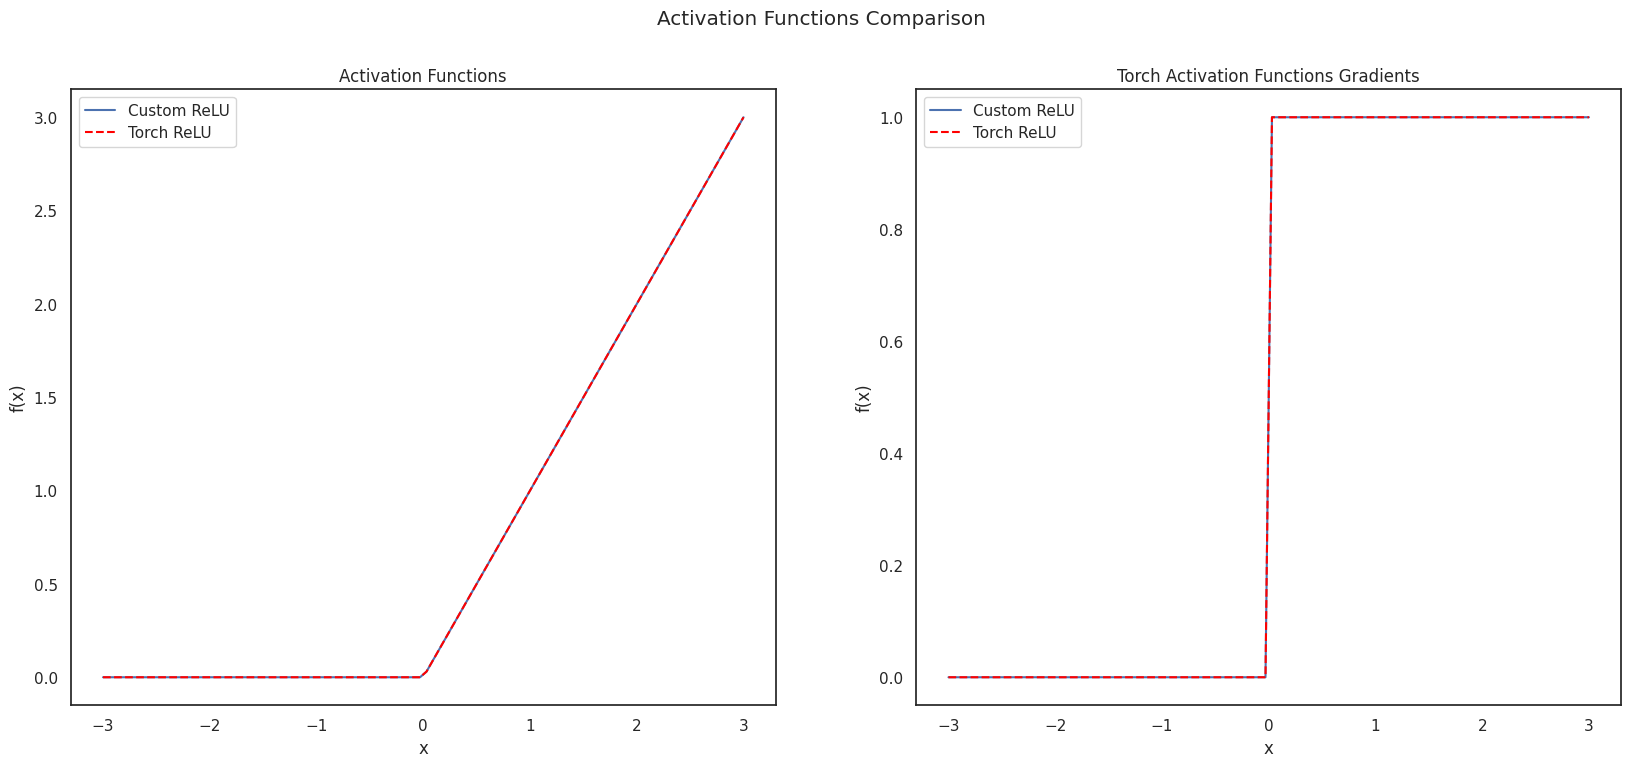

In [ ]:
# Plot custom and torch functions
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Activation Functions Comparison")

# Plot Custom Functions
axes[0].set_title("Activation Functions")
axes[0].plot(x.detach().numpy(), x_relu_custom.detach().numpy(), label="Custom ReLU")
axes[0].plot(x.detach().numpy(), x_relu_torch.detach().numpy(), color='red', label="Torch ReLU", linestyle='--')
axes[0].legend()
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")

# Plot Torch Functions
axes[1].set_title("Torch Activation Functions Gradients")
axes[1].plot(x.detach().numpy(), grad_relu_custom.detach().numpy(), label="Custom ReLU")
axes[1].plot(x.detach().numpy(), grad_relu_torch.detach().numpy(), color='red', label="Torch ReLU", linestyle='--')
axes[1].legend()
axes[1].set_xlabel("x")
axes[1].set_ylabel("f(x)")

plt.show()

In [ ]:
class LeakyReLU(nn.Module):
  def __init__(self, alpha):
    super().__init__()
    self.alpha = alpha


  def forward(self, x):
    return torch.maximum(self.alpha * x, x)

  def backward(self, x):
    grads = torch.ones_like(x)
    grads[x <= 0] = self.alpha
    return grads

class Tanh(nn.Module):
  def __init__(self, ):
    super().__init__()


  def forward(self, x):
    return torch.tanh(x)

  def backward(self, x):
    return 1 - torch.tanh(x) ** 2

In [ ]:
# lets test your functions with torch functions

torch_leaky_relu = nn.LeakyReLU(negative_slope=0.01)
torch_tanh = nn.Tanh()


your_leaky_relu = LeakyReLU(alpha=0.01)
your_tanh = Tanh()

In [ ]:
# Test forward pass
x_leaky_custom = your_leaky_relu(x)
x_leaky_torch = torch_leaky_relu(x)

assert torch.allclose(x_leaky_custom, x_leaky_torch)

x_tanh_custom = your_tanh(x)
x_tanh_torch = torch_tanh(x)

assert torch.allclose(x_tanh_custom, x_tanh_torch)


In [ ]:
grad_leaky_custom = your_leaky_relu.backward(x)


x.grad.zero_()
x_leaky_torch.sum().backward()
grad_leaky_torch = x.grad.clone()

assert torch.allclose(grad_leaky_custom, grad_leaky_torch)

grad_tanh_custom = your_tanh.backward(x)

x.grad.zero_()
x_tanh_torch.sum().backward()
grad_tanh_torch = x.grad.clone()


assert torch.allclose(grad_tanh_custom, grad_tanh_torch)


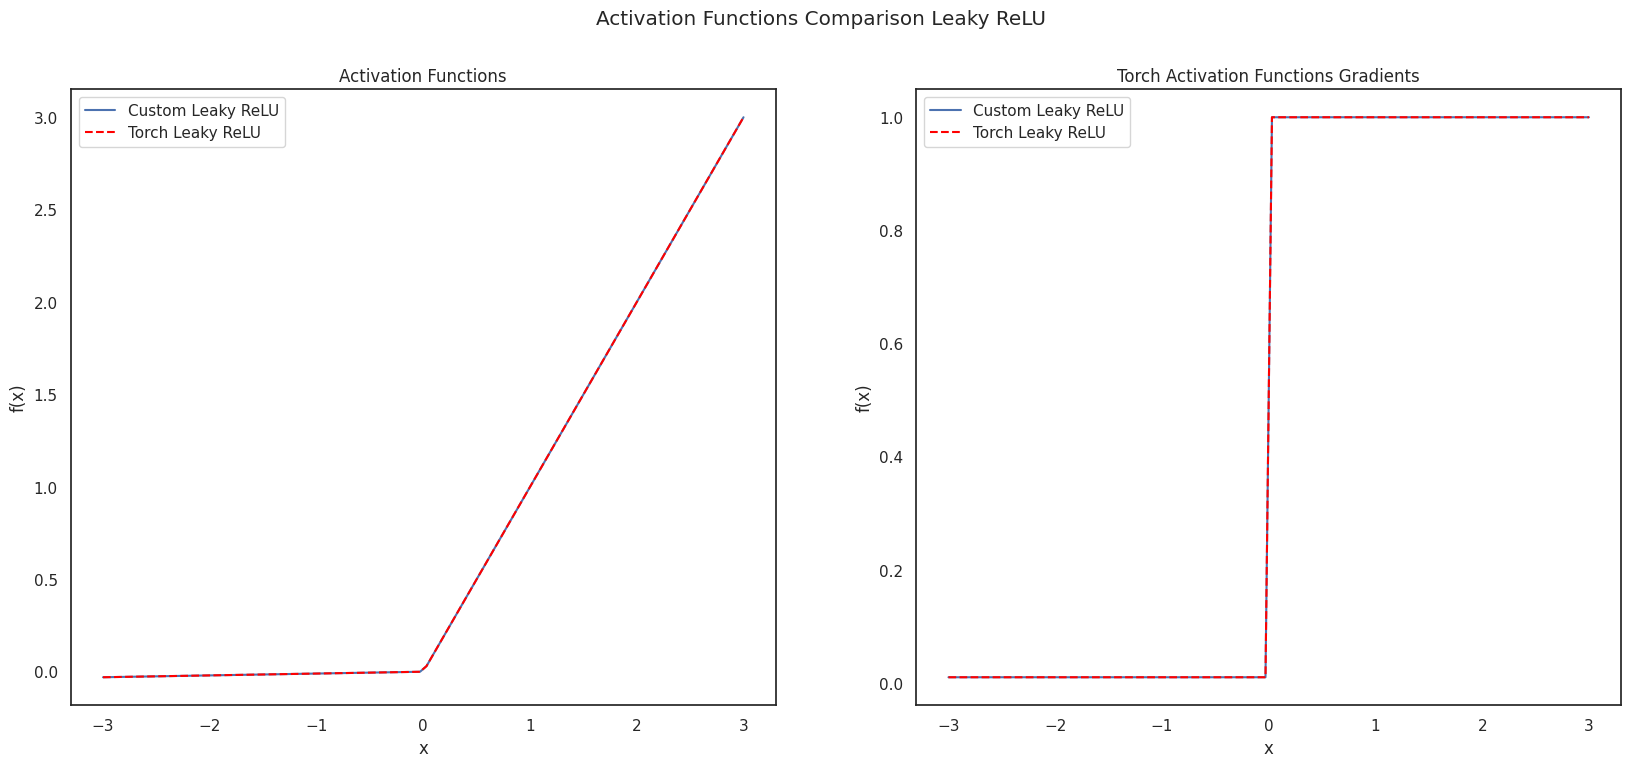

In [ ]:
# Plot custom and torch functions
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Activation Functions Comparison Leaky ReLU")

# Plot Custom Functions
axes[0].set_title("Activation Functions")
axes[0].plot(x.detach().numpy(), x_leaky_custom.detach().numpy(), label="Custom Leaky ReLU")
axes[0].plot(x.detach().numpy(), x_leaky_torch.detach().numpy(), color='red', label="Torch Leaky ReLU", linestyle='--')
axes[0].legend()
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")

# Plot Torch Functions
axes[1].set_title("Torch Activation Functions Gradients")
axes[1].plot(x.detach().numpy(), grad_leaky_custom.detach().numpy(), label="Custom Leaky ReLU")
axes[1].plot(x.detach().numpy(), grad_leaky_torch.detach().numpy(), color='red', label="Torch Leaky ReLU", linestyle='--')
axes[1].legend()
axes[1].set_xlabel("x")
axes[1].set_ylabel("f(x)")

plt.show()

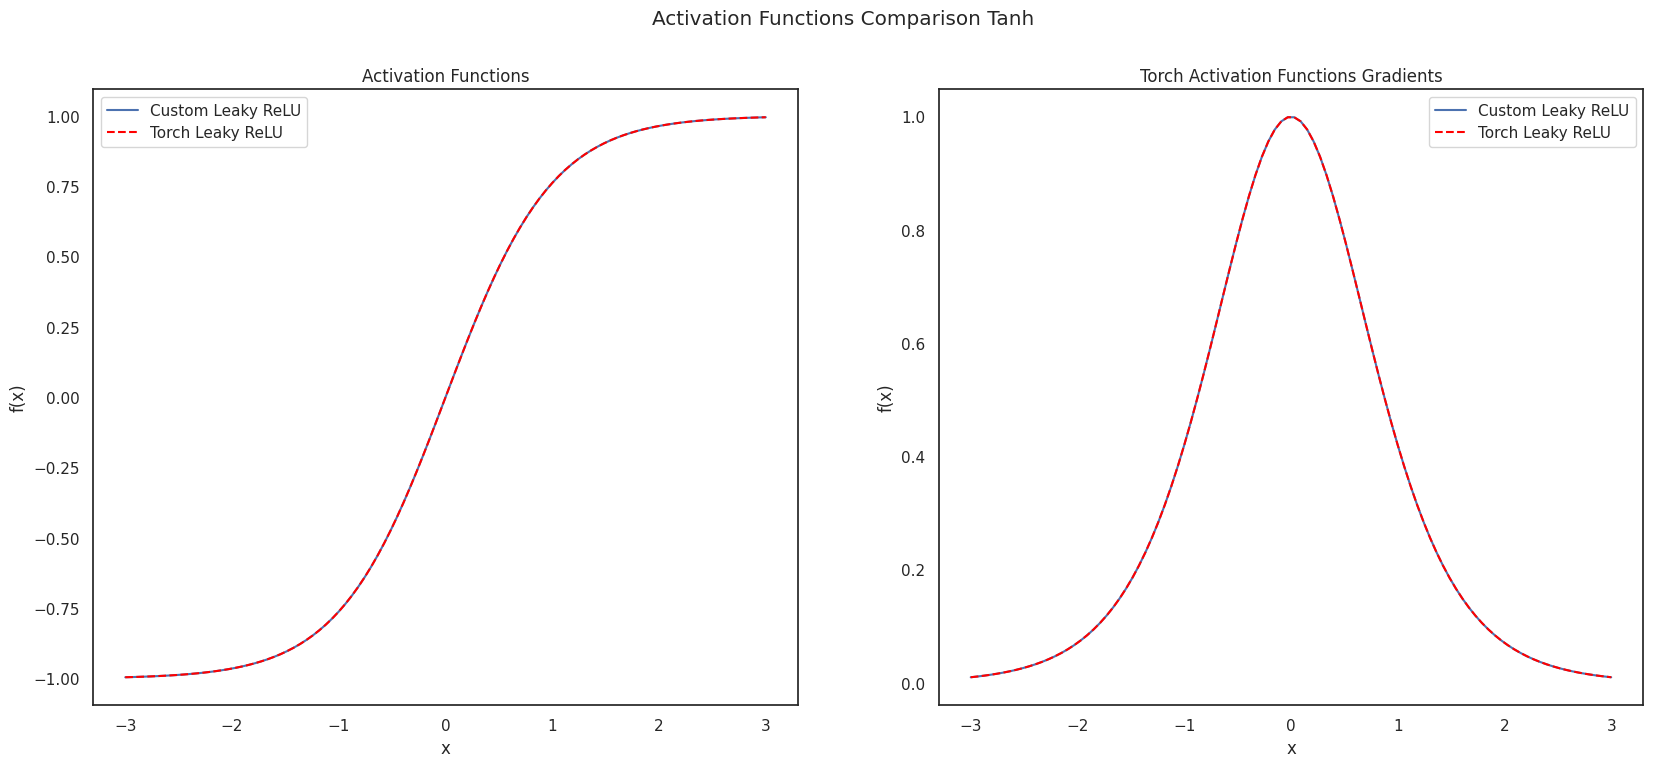

In [ ]:
# Plot custom and torch functions
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Activation Functions Comparison Tanh")

# Plot Custom Functions
axes[0].set_title("Activation Functions")
axes[0].plot(x.detach().numpy(), x_tanh_custom.detach().numpy(), label="Custom Leaky ReLU")
axes[0].plot(x.detach().numpy(), x_tanh_torch.detach().numpy(), color='red', label="Torch Leaky ReLU", linestyle='--')
axes[0].legend()
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")

# Plot Torch Functions
axes[1].set_title("Torch Activation Functions Gradients")
axes[1].plot(x.detach().numpy(), grad_tanh_custom.detach().numpy(), label="Custom Leaky ReLU")
axes[1].plot(x.detach().numpy(), grad_tanh_torch.detach().numpy(), color='red', label="Torch Leaky ReLU", linestyle='--')
axes[1].legend()
axes[1].set_xlabel("x")
axes[1].set_ylabel("f(x)")

plt.show()

In [ ]:
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        Linear(28*28, 128),
        activation,
        Linear(128, 128),
        activation,
        Linear(128, 10)
        )
    optimizer = torch.optim.Adam(model.parameters())
    max_epochs = 10
    accuracy = train_func(model = model, num_epochs = max_epochs, dataloaders = loaders_MNIST, optimizer = optimizer, loss_func = criterion)

    return accuracy

In [ ]:
plain_accuracy = test_activation_function(activation = nn.Identity())['valid'] #There is no non-linearity
relu_accuracy = test_activation_function(activation = nn.ReLU())['valid']
leaky_relu_accuracy = test_activation_function(activation = nn.LeakyReLU(negative_slope=0.01))['valid']
tanh_accuracy = test_activation_function(activation = nn.Tanh())['valid']


Epoch: 1


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.8489500284194946



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.8931000232696533


Epoch: 2


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.8826500177383423



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.8986999988555908


Epoch: 3


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.8900499939918518



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.8859000205993652


Epoch: 4


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.8950333595275879



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.8921999931335449


Epoch: 5


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.8963833451271057



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.900600016117096


Epoch: 6


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.8978333473205566



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.894599974155426


Epoch: 7


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.8996666669845581



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9003999829292297


Epoch: 8


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9011833071708679



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.902899980545044


Epoch: 9


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9002833366394043



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9061999917030334


Epoch: 10


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.902483344078064



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9154000282287598


Epoch: 1


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9003499746322632



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9337000250816345


Epoch: 2


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9423499703407288



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9449999928474426


Epoch: 3


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9518833160400391



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9514999985694885


Epoch: 4


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9553166627883911



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.930400013923645


Epoch: 5


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9580000042915344



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9521999955177307


Epoch: 6


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9607666730880737



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9585000276565552


Epoch: 7


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.961650013923645



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9638000130653381


Epoch: 8


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9632166624069214



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9553999900817871


Epoch: 9


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.963533341884613



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9521999955177307


Epoch: 10


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.964033305644989



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9599999785423279


Epoch: 1


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9034833312034607



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9477999806404114


Epoch: 2


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.945983350276947



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9528999924659729


Epoch: 3


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9532166719436646



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9532999992370605


Epoch: 4


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9582333564758301



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9557999968528748


Epoch: 5


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9599499702453613



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9603999853134155


Epoch: 6


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9621999859809875



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9659000039100647


Epoch: 7


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9641000032424927



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9581000208854675


Epoch: 8


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9662166833877563



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9653000235557556


Epoch: 9


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9667500257492065



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9599000215530396


Epoch: 10


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9673666954040527



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9538000226020813


Epoch: 1


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.8622499704360962



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9000999927520752


Epoch: 2


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.8960999846458435



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9009000062942505


Epoch: 3


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9039999842643738



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.8873999714851379


Epoch: 4


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9104999899864197



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9054999947547913


Epoch: 5


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9139500260353088



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9273999929428101


Epoch: 6


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9192000031471252



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9115999937057495


Epoch: 7


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9225000143051147



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9286999702453613


Epoch: 8


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9218999743461609



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9194999933242798


Epoch: 9


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9231500029563904



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9063000082969666


Epoch: 10


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9240666627883911



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9200000166893005



In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F


In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2025-11-12 14:32:50--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   158KB/s    in 0.3s    

2025-11-12 14:32:51 (158 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



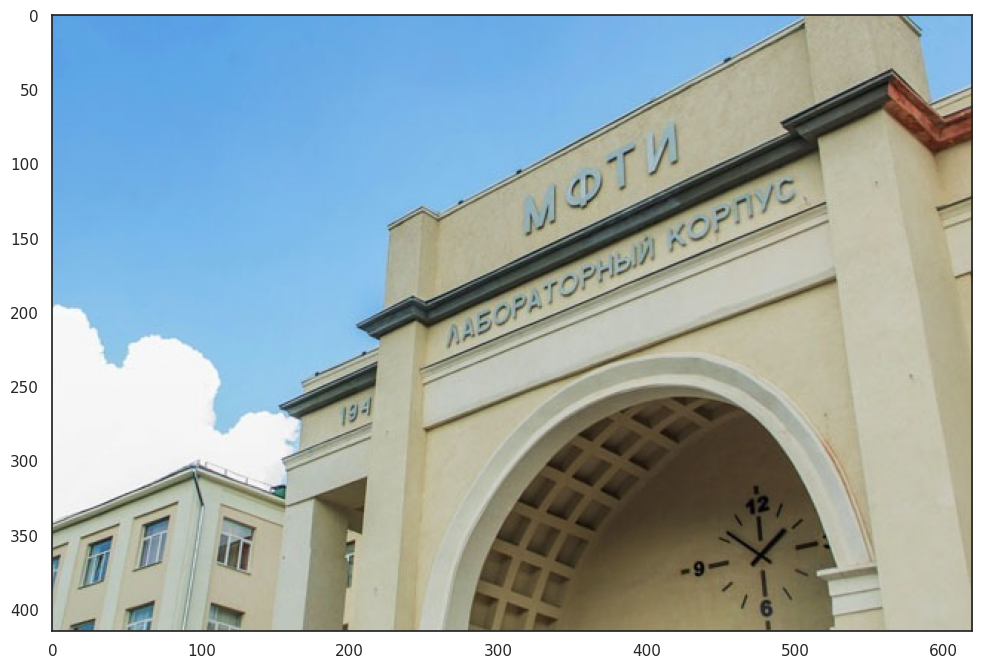

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

In [ ]:
conv_1 = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) # A
conv_2 = np.array([[0, 1, 0], [0, -2, 0], [0, 1, 0]]) # Б
conv_3 = np.array([[0, 0, 0], [1, -2, 1], [0, 0, 0]]) # В
conv_4 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]) # Г
conv_5 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) # Д
conv_6 = np.array([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]]) # E
conv_7 = np.array([[1, 0, 1], [0, 1, -1], [-2, 1, 0]])

In [ ]:
def show_conv_transformation(image, convolution):
  img_t = torch.from_numpy(image).type(torch.float32).unsqueeze(0)
  img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
  img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

  kernel = torch.tensor(convolution).reshape(1, 1, 3, 3).type(torch.float32)
  kernel = kernel.repeat(3, 3, 1, 1)

  result = F.conv2d(img_t, kernel)[0]
  result = torch.clip(input = result, min = 0, max = 256*3)

  plt.figure(figsize=(12, 8))
  result_np = result.permute(1, 2, 0).numpy() / 256 / 3
  plt.imshow(result_np)
  plt.show()

  return None

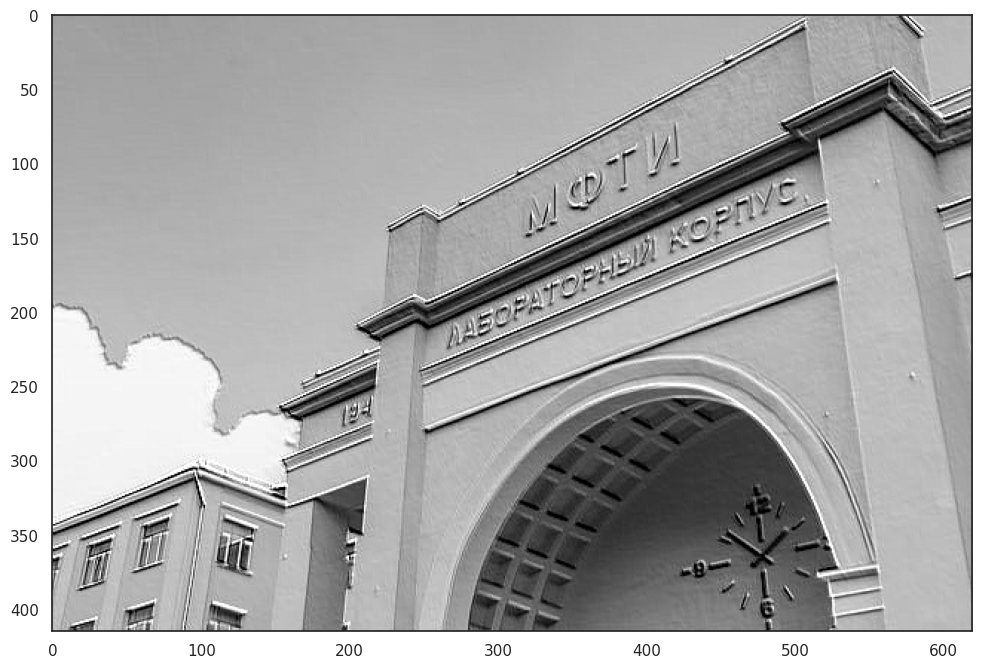

In [ ]:
show_conv_transformation(image = RGB_img, convolution = conv_7)

Задание. Реализуйте класс модели LeNet
Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году! На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из

Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
MaxPooling-а 2x2;
Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
MaxPooling-а 2x2;
Уплощения (nn.Flatten);
Полносвязного слоя со 120 нейронами и активацией ReLU;
Полносвязного слоя с 84 нейронами и активацией ReLU;
Выходного слоя из 10 нейронов.

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3)
        self.pool2 = nn.MaxPool2d(kernel_size = 2)

        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(in_features = 400, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)
        self.fc3 = nn.Linear(in_features = 84, out_features = 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.fl(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model_LeNet = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_LeNet.parameters())

loaders_MNIST = {"train": train_dataloader_MNIST, "valid": valid_dataloader_MNIST}

Задание. Обучите CNN-модель
Используйте функцию для обучения модели из части задания про полносвязные нейронные сети.

В качестве возможных улучшений рекомендуем добавить туда:

Валидацию каждые n шаговь

Добавить сохранение промежуточных весов. Может так получиться, что с какого-то момента модель начинает переобучаться и использование весов с более ранних шагов даёт более качественный результат. Именно поэтому полезно сохранять веса не только после последней эпохи, но и с промежуточных этапов обучения.

In [ ]:
max_epochs = 10
accuracy_LeNet = train_func(model = model_LeNet, num_epochs = max_epochs, dataloaders = loaders_MNIST, optimizer = optimizer, loss_func = criterion)


Epoch: 1


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9545666575431824



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9839000105857849


Epoch: 2


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9817166924476624



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9869999885559082


Epoch: 3


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9867333173751831



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9876999855041504


Epoch: 4


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9889666438102722



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9848999977111816


Epoch: 5


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9901833534240723



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9850000143051147


Epoch: 6


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9915666580200195



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9872999787330627


Epoch: 7


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.991683304309845



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9855999946594238


Epoch: 8


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9922500252723694



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9851999878883362


Epoch: 9


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9929999709129333



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9872000217437744


Epoch: 10


  0%|          | 0/15000 [00:00<?, ?it/s]

Accuracy_train: 0.9937333464622498



  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy_test: 0.9869999885559082



In [ ]:
lenet_accuracy = accuracy["valid"]

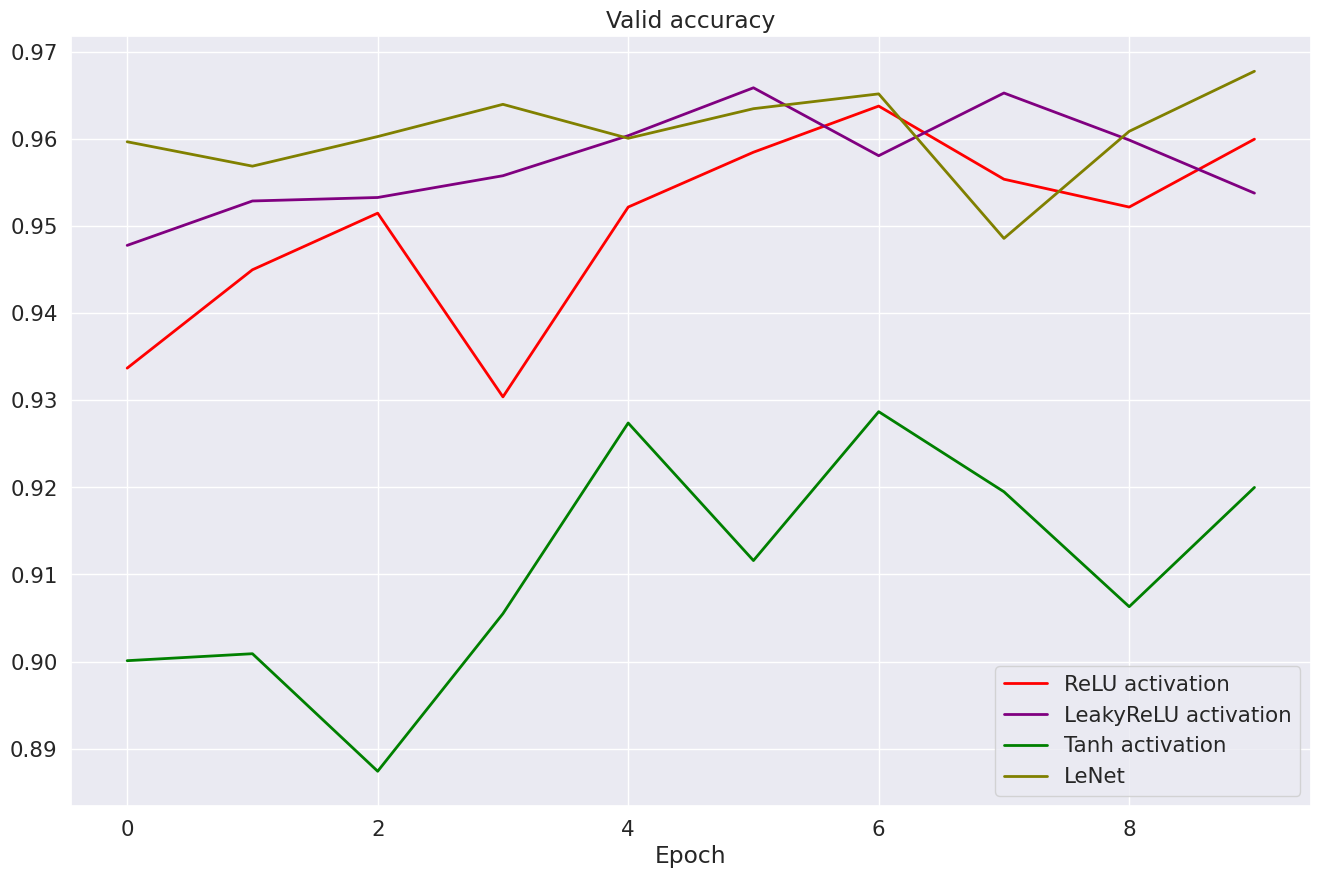

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2, color = 'red')
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2, color = 'purple')
plt.plot(range(max_epochs), tanh_accuracy, label="Tanh activation", linewidth=2, color = 'green')
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2, color = 'olive')
plt.legend()
plt.xlabel("Epoch")
plt.show()